## Installing Packages

In [2]:
!pip install arviz
!pip install pymc3==3.8

## Import Packages

In [3]:
# !pip install pymc3
import theano
from theano import tensor as tt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from theano import shared
from collections import OrderedDict
from time import time
import pymc3 as pm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import bs4 as bs
import urllib.request
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pystan
from scipy.stats import multivariate_normal
import operator
import arviz
import pandas as pd



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## PyStan

In [0]:
sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(alpha, 3);
    y ~ normal(alpha + beta * x, sigma);
}
"""

In [0]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

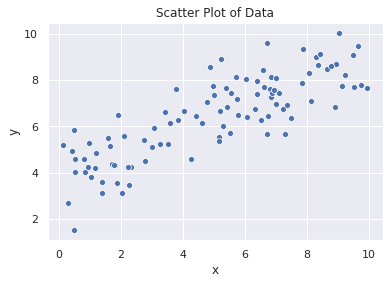

In [0]:
fig, ax = plt.subplots()
sns.scatterplot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')
fig.show()

In [0]:
my_data = {'N': len(x), 'x':x, 'y':y}

# compile the model
sm = pystan.StanModel(model_code = model)

# Train the model and generate samples
fit = sm.sampling(data=my_data, iter=1000, chains=4, warmup=500,
                 thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5dac76512503e16d165a1650e73d6591 NOW.


In [0]:
fit

Inference for Stan model: anon_model_5dac76512503e16d165a1650e73d6591.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  6.3e-3   0.19   3.47   3.73   3.85   3.98   4.22    941    1.0
beta    0.52  1.1e-3   0.03   0.45    0.5   0.52   0.54   0.59    949    1.0
sigma   1.01  2.1e-3   0.07   0.87   0.96    1.0   1.05   1.16   1195    1.0
lp__  -50.62    0.04   1.21 -53.75 -51.14 -50.31 -49.76 -49.26    739   1.01

Samples were drawn using NUTS at Fri May  1 14:04:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [0]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

In [0]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.851095,0.006284,0.192745,3.465029,3.726258,3.848893,3.984271,4.224171,940.701224,0.999217
beta,0.518369,0.001097,0.033787,0.452315,0.496904,0.518582,0.539565,0.587794,948.611362,0.999069
sigma,1.007607,0.002127,0.073528,0.870975,0.958357,1.002887,1.054083,1.159258,1194.621102,0.999689
lp__,-50.623869,0.044570,1.211308,-53.754838,-51.141953,-50.313697,-49.756458,-49.262103,738.640284,1.005184


In [0]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

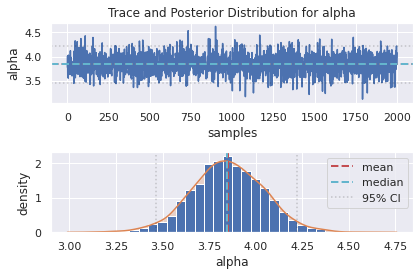

In [0]:
plot_trace(alpha, 'alpha')

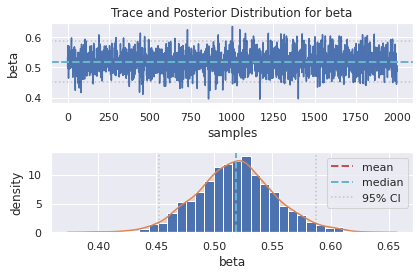

In [0]:
plot_trace(beta, 'beta')

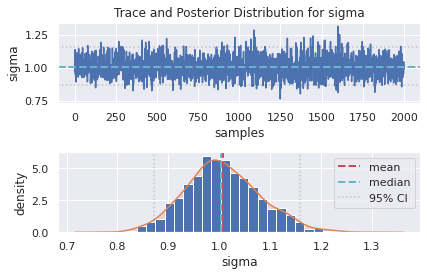

In [0]:
plot_trace(sigma, 'sigma')

## PyMC3

### Dirichlet Process

### Stick Breaking

In [0]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [0]:
dp = pm.Model()

with dp:
    alpha = 10*pm.Gamma('alpha', 1, 1)
    beta = pm.Beta('beta', 1, alpha, shape=5)
    pi = pm.Deterministic('pi', stick_breaking(beta))
    
with dp:
    trace = pm.sample(8, tune=10, init='advi', random_seed=1)

Only 8 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 1.4419:   3%|▎         | 5501/200000 [00:02<01:29, 2173.86it/s]
Convergence achieved at 5700
INFO:pymc3.variational.inference:Convergence achieved at 5700
Interrupted at 5,699 [2%]: Average Loss = 1.7765
INFO:pymc3.variational.inference:Interrupted at 5,699 [2%]: Average Loss = 1.7765
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
INFO:pymc3:NUTS: [beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 18/18 [00:00<00:00, 222.46it/s]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [0]:
trace['pi']

array([[0.0907542 , 0.03268845, 0.10681974, 0.00154636, 0.03765784],
       [0.02032622, 0.05671762, 0.02270593, 0.06834012, 0.03102234],
       [0.00726468, 0.04950976, 0.05235337, 0.03049507, 0.07304193],
       [0.09953672, 0.09950337, 0.06393129, 0.02337757, 0.04068965],
       [0.06077069, 0.08130527, 0.04558043, 0.06816003, 0.01682435],
       [0.07808966, 0.12482919, 0.03681067, 0.06957353, 0.01144041],
       [0.18070871, 0.06880308, 0.01003572, 0.12505519, 0.0046502 ],
       [0.13624294, 0.26413715, 0.00397311, 0.06933693, 0.00525164],
       [0.0032423 , 0.10861019, 0.00629521, 0.06634046, 0.01362621],
       [0.06646199, 0.07859136, 0.33180961, 0.02716244, 0.02176644],
       [0.15532472, 0.10900996, 0.19335546, 0.02987739, 0.03079586],
       [0.20260265, 0.02610849, 0.12721687, 0.17554193, 0.03491387],
       [0.18510847, 0.04371338, 0.24707375, 0.0957206 , 0.02869998],
       [0.124406  , 0.04529212, 0.31478542, 0.06872658, 0.04671427],
       [0.02597264, 0.01906084, 0.

In [0]:
trace['alpha']

array([0.53756939, 2.25785527, 1.21799756, 2.0338532 , 0.82152109,
       1.07704433, 1.10513914, 0.812967  , 2.22205993, 0.64550302,
       0.88478102, 0.89755924, 0.28673078, 0.37909996, 1.28634428,
       2.12617132])

## DP Mixture Model with MCMC and ADVI

### DP Mixture

In [0]:
# import some data to play with
iris = datasets.load_iris()
# iris['data']

In [0]:
# faith = pd.read_csv('faithful.csv')
# faith.waiting.values

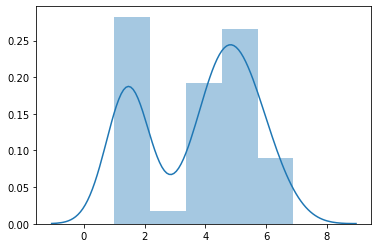

In [0]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# data = faith.waiting.values
data = iris['data'][:,2]
import seaborn as sns
sns.distplot(data)

In [0]:
K = 30

with pm.Model() as model:
    # alpha = pm.Gamma('alpha', 1., 1.)
    alpha = alpha
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=data)

### MCMC

In [0]:
SEED = 1
with model:
    # step_metro = pm.step_methods.metropolis.Metropolis()
    # step_hmc = pm.step_methods.hmc.hmc.HamiltonianMC()
    step_nuts = pm.step_methods.hmc.nuts.NUTS()
    
    step = step_nuts
    trace = pm.sample(200, step, random_seed=SEED, init='advi')

MissingInputError: ignored

alpha

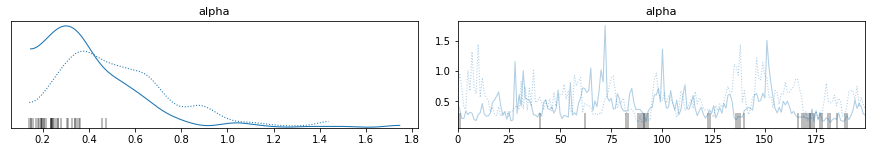

In [0]:
pm.traceplot(trace, var_names=['alpha']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc59a9e8208>,
      dtype=object)

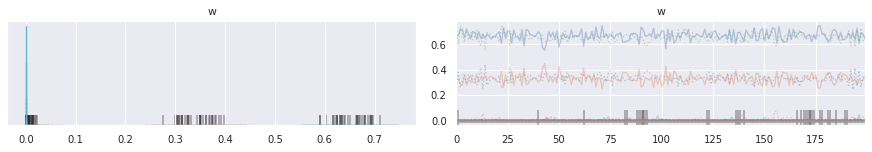

In [0]:
pm.traceplot(trace, var_names=['w'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc59a9a3c88>,
      dtype=object)

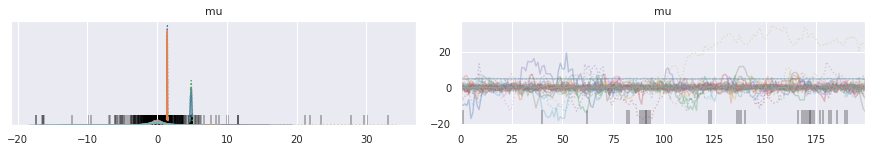

In [0]:
pm.traceplot(trace, var_names=['mu'])

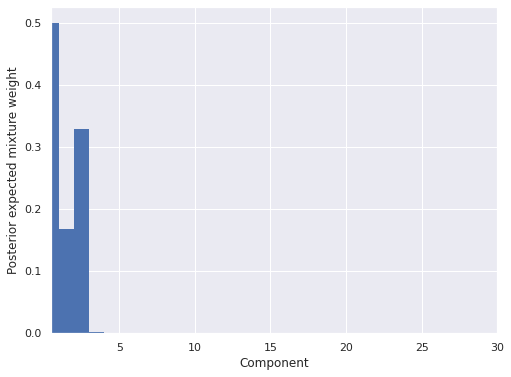

In [0]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

### ADVI

In [0]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
# doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
# doc_t = shared(docs_tr.toarray()[:minibatch_size])

# local_RVs = OrderedDict([alpha, beta, mu])
    
with model:
#     approx = pm.MeanField(local_rv=local_RVs)
    approx = pm.MeanField()
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    inference.fit(10000, callbacks=[reduce_rate], 
              obj_optimizer=pm.sgd(learning_rate=s))
#               more_obj_params=encoder_params, 
#               total_grad_norm_constraint=200,
#               more_replacements={doc_t: doc_t_minibatch})
                  

Average Loss = inf:   0%|          | 0/10000 [00:00<?, ?it/s]


FloatingPointError: ignored

In [0]:
with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

In [0]:
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

In [0]:
means.keys()

In [0]:
plt.plot(means['mu'])

In [0]:
plt.plot(means['tau_log__'])

In [0]:
plt.plot(cov)

## Multivariate Normal Mixture HDP

### Univariate Normal HDP

In [0]:
from sklearn import datasets
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# import some data to play with
iris = datasets.load_iris()
iris['data']

# univariate data
# data = faith.waiting.values
# data = iris['data'][:,1]
mu_1, sigma_1 = 0, 1.5 # mean and standard deviation
mu_2, sigma_2 = 18, 5
mu_3, sigma_3 = -3, 3
# mu_4, simga_4 = 
# mu_5, simga_5 =
s_1 = list(np.random.normal(mu_1, sigma_1, 50))
s_2 = list(np.random.normal(mu_2, sigma_2, 50))
s_3 = list(np.random.normal(mu_3, sigma_3, 50))

uni_data = s_1 + s_2 + s_3
sns.distplot(uni_data, rug=True)
print(len(uni_data))

uni_data_cat = ['1' for i in range(50)] + ['2' for i in range(50)] +['3' for i in range(50)]
uni_data_frame = pd.DataFrame({'uni_data': uni_data, 'cat': uni_data_cat})
# print(uni_data_frame)
sns.pairplot(uni_data_frame,hue = 'cat')


# define dataset
data = uni_data

dim = np.shape(data)[0]
dim

In [0]:
SEED = 1
K_topics = 50
M_topics_per_doc = 20
atoms = np.random.normal(0, .01, K_topics)

# Custom distribution in PyMC3
# def logp_G0(atoms, w, value):
#     idx = np.where(atoms == value)[0]   # Example return value: (array([], dtype=int32),)
#     if len(idx) == 0:
#       return 0
#     return log(w[idx[0]])


with pm.Model() as hdp_model:
    
    # Topics DP
    alpha_0 = pm.Gamma('alpha_0', 1., 1.)
    beta_0 = pm.Beta('beta_0', 1., alpha_0, shape=K_topics)
    w_0 = pm.Deterministic('w_0', stick_breaking(beta_0))

    # Get samples from normal 
    tau_0 = pm.Gamma('tau_0', 1., 1., shape=K_topics)
    lambda_0 = pm.Uniform('lambda_0', 0, 5, shape=K_topics)
    mu_0 = pm.Normal('mu_0', np.zeros(K_topics), tau=1, shape=K_topics)
    # atoms = pm.Normal('atoms', np.zeros(K_topics), tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?
    atoms = pm.Normal('atoms', mu_0, tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?

    # Need to get samples from G0 --> these become the mu's for the final dist
    # sample_theta = np.random.choice(atoms, M_topics_per_doc, p=w_0)
    # https://discourse.pymc.io/t/multivariatre-categorical-variable-with-different-values/1008/2
    tmp = pm.Categorical('tmp', w_0, shape=M_topics_per_doc)
    sample_theta = pm.Deterministic('shared_theta', atoms[tmp])

    # Want G0 to be atoms in second level of HDP
    # G0 = pm.DensityDist('G0', logp_G0, observed={'atoms':atoms, 'w':w_0, 'value': sample_theta})
    
    # mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)   # I don't think we want this to be a RV
    
    # obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
    #                        observed=data)

    tau_j = pm.Gamma('tau_j', 1., 1., shape=M_topics_per_doc)
    lambda_j = pm.Uniform('lambda_j', 0, 5, shape=M_topics_per_doc)
    # Doc DP
    alpha_j = pm.Gamma('alpha_j', 1., 1.)   # We can choose to use the same alpha_0 as above
    beta_j = pm.Beta('beta_j', 1., alpha_j, shape=M_topics_per_doc)    # Same comment as above
    w_j = pm.Deterministic('w_j', stick_breaking(beta_j))

    obs = pm.NormalMixture('obs', w_j, sample_theta, tau=lambda_j * tau_j, observed=data)
    
    # cov = np.array([[1., 0.5], [0.5, 2]])
    # mu = np.zeros(2)
    # vals = pm.MvNormal('vals', mu=mu, cov=cov, shape=(5, 2), observed=data)

In [0]:
print(hdp_model.basic_RVs)

In [0]:
with hdp_model:
    step_metro = pm.step_methods.metropolis.Metropolis()
    step_hmc = pm.step_methods.hmc.hmc.HamiltonianMC()
    step_nuts = pm.step_methods.hmc.nuts.NUTS()

    step = step_nuts
    trace = pm.sample(5000, step, random_seed=SEED, init='advi')#, exception_verbosity='high')

In [0]:
# with hdp_model:
#     approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

#### Traceplot for univariate hdp

In [0]:
pm.traceplot(trace, var_names=['alpha_0']);

In [0]:
print(trace['alpha_0'].mean(0))

In [0]:
pm.traceplot(trace, var_names=['beta_0']);

In [0]:
print(trace['beta_0'].mean(0))

In [0]:
len(trace['beta_0'].mean(1))

In [0]:
pm.traceplot(trace, var_names=['tau_0']);

In [0]:
pm.traceplot(trace, var_names=['lambda_0']);

In [0]:
pm.traceplot(trace, var_names=['mu_0'])

In [0]:
pm.traceplot(trace, var_names=['w_0']);

In [0]:
pm.traceplot(trace, var_names=['alpha_j']);

In [0]:
pm.traceplot(trace, var_names=['tau_j']);

In [0]:
pm.traceplot(trace, var_names=['lambda_j']);

In [0]:
pm.traceplot(trace, var_names=['tmp']);

In [0]:
trace['tmp'].mean(0)

In [0]:
pm.traceplot(trace, var_names=['atoms']);

In [0]:
len(trace['atoms'].mean(0))

In [0]:
pm.traceplot(trace, var_names=['w_j']);

### Multivariate Normal HDP

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


      Unnamed: 0        x1        x2
0              0  1.455661 -1.381612
1              1  1.036617 -1.114962
2              2  1.553669 -1.300412
3              3  1.374290 -0.872343
4              4  1.186451 -0.673791
...          ...       ...       ...
2495        2495 -1.135652 -0.978310
2496        2496 -1.442845 -0.184241
2497        2497 -1.223801 -0.040859
2498        2498 -1.031125 -0.595488
2499        2499 -0.970918 -0.943935

[2500 rows x 3 columns]


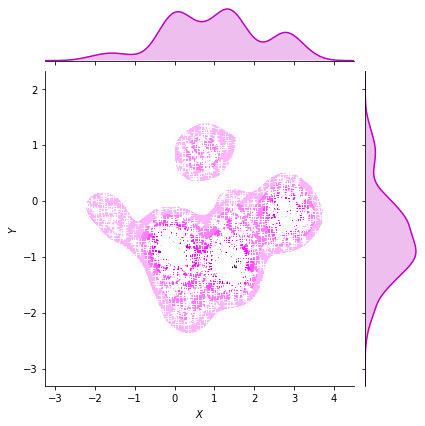

In [0]:
# multivariate data
dim = 2
mean1 = (1, 2)
mean2 = (-7, 20)
cov1 = [[1, 0], [0, 1]]
cov2 = [[0.7, 9.9], [4, 3.2]]
x1 = list(np.random.multivariate_normal(mean1, cov1, 50))
x2 = list(np.random.multivariate_normal(mean2, cov2, 50))
multi_data = x1 + x2

multi_data_cat = ['1' for i in range(50)] + ['2' for i in range(50)]

multi_data_frame = pd.DataFrame(multi_data)
multi_data_frame.columns = ['x1', 'x2']
multi_data_frame = pd.concat([multi_data_frame, pd.DataFrame({'cat': multi_data_cat})], axis=1)

multi_data_frame = pd.read_csv('/content/hdp_data-3.csv')
print(multi_data_frame)

g = sns.jointplot(x="x1", y="x2", data=multi_data_frame, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

# multi_data_list = pd.read_csv('/content/thdp_data.csv')
# multi_data_list = np.array_split(multi_data_list, 10)

# for multi_data_frame in multi_data_list:
#   g = sns.jointplot(x="x1", y="x2", data=multi_data_frame, kind="kde", color="m")
#   g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
#   g.ax_joint.collections[0].set_alpha(0)
#   g.set_axis_labels("$X$", "$Y$");

In [0]:
def MvNorm_HDP(data, K_topics, M_topics_per_doc, n_samples, mcmc): 

    def stick_breaking(beta):
      portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
      return beta * portion_remaining
    

    dim = np.shape(data)[1]

    cov_I = np.zeros((dim,dim))
    for i in range(dim):
      cov_I[i,i] = 1

    with pm.Model() as multivar_normal_hdp:

        ###################
        # Topics DP
        ###################
        alpha_0 = pm.Gamma('alpha_0', 1., 1.)
        beta_0 = pm.Beta('beta_0', 1., alpha_0, shape=K_topics)
        w_0 = pm.Deterministic('w_0', stick_breaking(beta_0))

        # Get samples from normal 
        # tau_0 = pm.Gamma('tau_0', 1., 1., shape=K_topics)
        # lambda_0 = pm.Uniform('lambda_0', 0, 5, shape=K_topics)

        mu_0 = pm.MvNormal('mu_0', np.zeros(dim), tau=cov_I, shape=(K_topics, dim))
        # atoms = pm.Normal('atoms', np.zeros(K_topics), tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?

        # set a prior on the covariance
        packed_L = pm.LKJCholeskyCov('packed_L', n=dim,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(dim, packed_L)
        cov0 = pm.Deterministic('cov0', L.dot(L.T))
     
        atoms = pm.MvNormal('atoms', mu_0, tau=cov0, shape=(K_topics, dim))  # Should this be a RV?

        tmp = pm.Categorical('tmp', w_0, shape=M_topics_per_doc)
        sample_theta = pm.Deterministic('shared_theta', atoms[tmp])

        # tau_j = pm.Gamma('tau_j', 1., 1., shape=M_topics_per_doc)
        # lambda_j = pm.Uniform('lambda_j', 0, 5, shape=M_topics_per_doc)

        ###################
        # Doc DP
        ###################

        # for doc in docs:

        alpha_j = pm.Gamma('alpha_j', 1., 1.)   # We can choose to use the same alpha_0 as above
        beta_j = pm.Beta('beta_j', 1., alpha_j, shape=M_topics_per_doc)    # Same comment as above
        w_j = pm.Deterministic('w_j', stick_breaking(beta_j))

        comp_dists_list = []
        for m in range(M_topics_per_doc):

          # set a prior on the covariance matrix
          packed_L_m = pm.LKJCholeskyCov('packed_L_'+str(m), n=dim,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
          L_m = pm.expand_packed_triangular(dim, packed_L_m)
          cov_m = pm.Deterministic('cov_'+str(m), L_m.dot(L_m.T))


          normal_m = pm.MvNormal('normal_'+str(m), sample_theta[m], tau=cov_m, shape=dim)
          comp_dists_list.append(normal_m.distribution)

        obs = pm.Mixture('obs', w_j, comp_dists = comp_dists_list, shape = M_topics_per_doc, 
                        #  observed=iris['data'][:,1:3])
                        observed=data)


    with multivar_normal_hdp:
        step_nuts = pm.step_methods.hmc.nuts.NUTS()
        step_metro = pm.step_methods.metropolis.Metropolis()

        if mcmc == 'nuts':
          step = step_nuts
        elif mcmc == 'metro':
          step = step_metro
        trace_multivar = pm.sample(n_samples, step, random_seed=SEED, init='advi')
    return trace_multivar, multivar_normal_hdp

In [0]:
SEED = 1
K_topics = 50
M_topics_per_doc = 20
atoms = np.random.normal(0, .01, K_topics)

dim = dim # dimension of word vectors

# for now I have assumed all covariance matrices to be identity matrix
# We need to add priors on this later
# cov_I = np.array([[1, 0], [0, 1]])

# data = multi_data_frame.iloc[:, :2]
# n_samples = 2000
# mcmc = 'nuts'

# trace_multivar, multivar_normal_hdp = MvNorm_HDP(data, K_topics, M_topics_per_doc, n_samples, mcmc)

n_samples = 2000
mcmc = 'nuts'
for multi_data_frame in multi_data_list:
  data = multi_data_frame.iloc[:, :2]
  trace_multivar, multivar_normal_hdp = MvNorm_HDP(data, K_topics, M_topics_per_doc, n_samples, mcmc)


In [0]:
print(multivar_normal_hdp.basic_RVs)

In [0]:
pm.traceplot(trace_multivar, var_names=['normal_0'])
pm.traceplot(trace_multivar, var_names=['normal_1'])

In [0]:
pm.traceplot(trace_multivar, var_names=['alpha_1'])

In [0]:
pm.traceplot(trace_multivar, var_names=['w_j'])

In [0]:
## means of clusters

print('w: ', trace_multivar['w_j'].mean(0))

for i in range(M_topics_per_doc):
  print('normal_'+str(i)+': ', trace_multivar['normal_'+str(i)].mean(0))


### MvNormal HDP over Corpus

In [5]:
multi_data_frame = pd.read_csv('/content/hdp_data-3.csv')
multi_data_doc = np.array_split(multi_data_list, 10)

NameError: ignored

In [0]:
def MvNorm_HDP(data, K_topics, M_topics_per_doc, n_samples, mcmc): 

    def stick_breaking(beta):
      portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
      return beta * portion_remaining
    

    dim = np.shape(data)[1]

    cov_I = np.zeros((dim,dim))
    for i in range(dim):
      cov_I[i,i] = 1

    with pm.Model() as multivar_normal_hdp:

        ###################
        # Topics DP
        ###################
        alpha_0 = pm.Gamma('alpha_0', 1., 1.)
        beta_0 = pm.Beta('beta_0', 1., alpha_0, shape=K_topics)
        w_0 = pm.Deterministic('w_0', stick_breaking(beta_0))

        # Get samples from normal 
        # tau_0 = pm.Gamma('tau_0', 1., 1., shape=K_topics)
        # lambda_0 = pm.Uniform('lambda_0', 0, 5, shape=K_topics)

        mu_0 = pm.MvNormal('mu_0', np.zeros(dim), tau=cov_I, shape=(K_topics, dim))
        # atoms = pm.Normal('atoms', np.zeros(K_topics), tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?

        # set a prior on the covariance
#         packed_L = pm.LKJCholeskyCov('packed_L', n=dim,
#                                  eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
#         L = pm.expand_packed_triangular(dim, packed_L)
#         cov0 = pm.Deterministic('cov0', L.dot(L.T))
     
        atoms = pm.MvNormal('atoms', mu_0, tau=cov_I, shape=(K_topics, dim))  # Should this be a RV?

        tmp = pm.Categorical('tmp', w_0, shape=M_topics_per_doc)
        sample_theta = pm.Deterministic('shared_theta', atoms[tmp])

        # tau_j = pm.Gamma('tau_j', 1., 1., shape=M_topics_per_doc)
        # lambda_j = pm.Uniform('lambda_j', 0, 5, shape=M_topics_per_doc)

        ###################
        # Doc DP
        ###################

        # for doc in docs:

        alpha_j = pm.Gamma('alpha_j', 1., 1.)   # We can choose to use the same alpha_0 as above
        beta_j = pm.Beta('beta_j', 1., alpha_j, shape=M_topics_per_doc)    # Same comment as above
        w_j = pm.Deterministic('w_j', stick_breaking(beta_j))

        comp_dists_list = []
        for m in range(M_topics_per_doc):

          # set a prior on the covariance matrix
#           packed_L_m = pm.LKJCholeskyCov('packed_L_'+str(m), n=dim,
#                                  eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
#           L_m = pm.expand_packed_triangular(dim, packed_L_m)
#           cov_m = pm.Deterministic('cov_'+str(m), L_m.dot(L_m.T))


          normal_m = pm.MvNormal('normal_'+str(m), sample_theta[m], tau=cov_I, shape=dim)
          comp_dists_list.append(normal_m.distribution)

        obs = pm.Mixture('obs', w_j, comp_dists = comp_dists_list, shape = M_topics_per_doc, 
                        #  observed=iris['data'][:,1:3])
                        observed=data)


    with multivar_normal_hdp:
        step_nuts = pm.step_methods.hmc.nuts.NUTS()
        step_metro = pm.step_methods.metropolis.Metropolis()

        if mcmc == 'nuts':
          step = step_nuts
        elif mcmc == 'metro':
          step = step_metro
        trace_multivar = pm.sample(n_samples, step, random_seed=SEED, init='advi')
    return trace_multivar, multivar_normal_hdp

### Multivariate Normal THDP

In [0]:
# multivariate data
dim = 2
# mean1 = (1, 2)
# mean2 = (-7, 20)
# cov1 = [[1, 0], [0, 1]]
# cov2 = [[0.7, 9.9], [4, 3.2]]
# x1 = list(np.random.multivariate_normal(mean1, cov1, 50))
# x2 = list(np.random.multivariate_normal(mean2, cov2, 50))
# multi_data = x1 + x2

multi_data_list = pd.read_csv('/content/thdp_data.csv')
multi_data_list = np.array_split(multi_data_list, 100)
# print(len(multi_data_list))

# for multi_data_frame in multi_data_list:
#   g = sns.jointplot(x="x1", y="x2", data=multi_data_frame, kind="kde", color="m")
#   g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
#   g.ax_joint.collections[0].set_alpha(0)
#   g.set_axis_labels("$X$", "$Y$");

In [0]:
def MvNorm_THDP(epoch, data, K_topics, M_topics_per_doc, n_samples, mcmc, alpha_0_t, beta_0_t, w_0_t, mu_0_t, multivar_normal_thdp): 

    def stick_breaking(beta):
      portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
      return beta * portion_remaining
    

    dim = np.shape(data)[1]

    cov_I = np.zeros((dim,dim))
    for i in range(dim):
      cov_I[i,i] = 1

    if not multivar_normal_thdp:
      multivar_normal_thdp = pm.Model()

    with multivar_normal_thdp:

        ###################
        # Topics DP
        ###################
        if not (alpha_0_t) and not (beta_0_t) and not w_0_t:
          alpha_0 = pm.Gamma('alpha_0', 1., 1.)
          beta_0 = pm.Beta('beta_0', 1., alpha_0, shape=K_topics)
          w_0 = pm.Deterministic('w_0', stick_breaking(beta_0))
          mu_0 = pm.MvNormal('mu_0', np.zeros(dim), tau=cov_I, shape=(K_topics, dim))

        else:
          alpha_0 = alpha_0_t
          beta_0 = beta_0_t
          w_0 = w_0_t
          mu_0 = mu_0_t
    
        # Get samples from normal 
        # tau_0 = pm.Gamma('tau_0', 1., 1., shape=K_topics)
        # lambda_0 = pm.Uniform('lambda_0', 0, 5, shape=K_topics)

        # atoms = pm.Normal('atoms', np.zeros(K_topics), tau=tau_0*lambda_0, shape=K_topics)  

        # set a prior on the covariance
        # packed_L = pm.LKJCholeskyCov('packed_L', n=dim,
        #                          eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        # L = pm.expand_packed_triangular(dim, packed_L)
        # cov0 = pm.Deterministic('cov0', L.dot(L.T))
     
        atoms = pm.MvNormal('atoms_epoch'+str(epoch), mu_0, tau=cov_I, shape=(K_topics, dim))  

        tmp = pm.Categorical('tmp_epoch'+str(epoch), w_0, shape=M_topics_per_doc)
        sample_theta = pm.Deterministic('shared_theta_epoch'+str(epoch), atoms[tmp])

        # tau_j = pm.Gamma('tau_j', 1., 1., shape=M_topics_per_doc)
        # lambda_j = pm.Uniform('lambda_j', 0, 5, shape=M_topics_per_doc)

        ###################
        # Doc DP
        ###################

        # for doc in docs:

        alpha_j = pm.Gamma('alpha_j_epoch'+str(epoch), 1., 1.)   # We can choose to use the same alpha_0 as above
        beta_j = pm.Beta('beta_j_epoch'+str(epoch), 1., alpha_j, shape=M_topics_per_doc)    # Same comment as above
        w_j = pm.Deterministic('w_j_epoch'+str(epoch), stick_breaking(beta_j))

        comp_dists_list = []
        for j in range(M_topics_per_doc):

          # set a prior on the covariance matrix
          # packed_L_m = pm.LKJCholeskyCov('packed_L_'+str(m), n=dim,
          #                        eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
          # L_m = pm.expand_packed_triangular(dim, packed_L_m)
          # cov_m = pm.Deterministic('cov_'+str(m), L_m.dot(L_m.T))


          normal_j = pm.MvNormal('normal_'+str(j)+'_epoch'+str(epoch), sample_theta[j], tau=cov_I, shape=dim)
          comp_dists_list.append(normal_j.distribution)

        print('Going through the data by obs')
        obs = pm.Mixture('obs_epoch'+str(epoch), w_j, comp_dists = comp_dists_list, shape = M_topics_per_doc, 
                        #  observed=iris['data'][:,1:3])
                        observed=data)
        print('Done going through data')

    with multivar_normal_thdp:

        print('just entered the mcmc part')
        # step_nuts = pm.step_methods.hmc.nuts.NUTS()
        # step_metro = pm.step_methods.metropolis.Metropolis()

        # if mcmc == 'nuts':
        #   step = step_nuts
        # # elif mcmc == 'metro':
        # else:
        #   step = step_metro

        print('Going to do sampling')
        # trace_multivar = pm.sample(n_samples, step, random_seed=SEED, init='advi')
        trace_multivar = pm.sample(n_samples, pm.step_methods.metropolis.Metropolis(), random_seed=SEED, init='advi')


    return trace_multivar, multivar_normal_thdp, alpha_0, beta_0, w_0, mu_0, alpha_j, beta_j, w_j, normal_j 

In [0]:
SEED = 1
K_topics = 50
M_topics_per_doc = 20
atoms = np.random.normal(0, .01, K_topics)

dim = 2 # dimension of word vectors

# for now I have assumed all covariance matrices to be identity matrix
# We need to add priors on this later
# cov_I = np.array([[1, 0], [0, 1]])

# print(multi_data_list[0])
# data_epoch_0 = multi_data_frame.iloc[:, :2].pop(0)
# data_epoch_0 = multi_data_list.pop(0)

n_samples = 2000
mcmc = 'mcmc'

epoch = 0
trace_multivar = {}
multivar_normal_hdp = {}
alpha_0_t = {}
beta_0_t = {}
w_0_t = {}
mu_0_t = {}

# for i in range(len(multi_data_list)):

#   doc_ind =  i%10  # index for each document
#   t_ind =  i//10. # index for each time step

alpha_j_t = {}
beta_j_t = {}
w_j_t = {}
normal_j_t = {}


n_samples = 2000
mcmc = 'metro'


print('length of data list: ', len(multi_data_list))
for i, multi_data_frame in enumerate(multi_data_list):

  doc_ind =  str(i%10)  # index for each document
  doc_ind_prev = str((i-1)%10)
  print('doc_ind: ', doc_ind)
  print('doc_ind_prev: ', doc_ind_prev)

  t_ind =  str(i//10) # index for each time step
  t_ind_prev =  str((i-1)//10) 
  print('t_ind: ', t_ind)
  print('t_ind_prev: ', t_ind_prev)

  jt = 'doc_' + str(doc_ind) + '_t' + str(t_ind) # doct j at time step t
  jt_prev = 'doc_' + str(doc_ind_prev) + '_t' + str(t_ind_prev) 
  print('doc_ind_time_t: ', jt)
  print('doc_ind_time_t_prev: ', jt_prev)

  data = multi_data_frame.iloc[:, 1:3]

  if i == 0:
    trace_multivar[jt], multivar_normal_hdp[jt], alpha_0_t[t_ind], beta_0_t[t_ind], w_0_t[t_ind], mu_0_t[t_ind], alpha_j_t[jt], beta_j_t[jt], w_j_t[jt], normal_j_t[jt]  = \
    MvNorm_THDP(epoch, data, K_topics, M_topics_per_doc, n_samples, mcmc, None, None, None, None, None)
    # print(type(alpha))
    # print('alpha: ', alpha_0_t[epoch])
    # print()
    # print('beta: ', beta_0_t[epoch])
    # print('w: ', w_0_t[epoch])
    # print('mu: ', mu_0_t[epoch])
  else:
    epoch += 1
    print('#######################')
    print('##### epoch: ', epoch)
    print('#######################')
    print('t_ind_prev: ', t_ind_prev)
    print('key for alpha: ', alpha_0_t.keys())
    print('item: ', alpha_0_t[t_ind_prev])
    print('multivariate normal hdp jt_prev: ', multivar_normal_hdp[jt_prev])
    trace_multivar[jt], multivar_normal_hdp[jt],alpha_0_t[t_ind], beta_0_t[t_ind], w_0_t[t_ind], mu_0_t[t_ind], alpha_j_t[jt], beta_j_t[jt], w_j_t[jt], normal_j_t[jt]  = \
    MvNorm_THDP(epoch, data, K_topics, M_topics_per_doc, n_samples, mcmc, alpha_0_t[t_ind_prev], beta_0_t[t_ind_prev], w_0_t[t_ind_prev], mu_0_t[t_ind_prev], multivar_normal_hdp[jt_prev])

  print(multivar_normal_hdp[jt].basic_RVs)

  pm.traceplot(trace_multivar[jt], var_names=['alpha_0'])
  pm.traceplot(trace_multivar[jt], var_names=['mu_0'])
  pm.traceplot(trace_multivar[jt], var_names=['atoms_epoch'+str(epoch)])
  pm.traceplot(trace_multivar[jt], var_names=['normal_1_epoch'+str(epoch)])
  pm.traceplot(trace_multivar[jt], var_names=['normal_8_epoch'+str(epoch)])
  pm.traceplot(trace_multivar[jt], var_names=['normal_16_epoch'+str(epoch)])

  ## means of clusters

  print('w: ', trace_multivar[jt]['w_j_epoch'+str(epoch)].mean(0))

  for i in range(M_topics_per_doc):
    print('normal_'+str(i)+': ', trace_multivar[jt]['normal_'+str(i)+'_epoch'+str(epoch)].mean(0))

length of data list:  100
doc_ind:  0
doc_ind_prev:  9
t_ind:  0
t_ind_prev:  -1
doc_ind_time_t:  doc_0_t0
doc_ind_time_t_prev:  doc_9_t-1
Going through the data by obs
Done going through data
just entered the mcmc part
Going to do sampling


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [normal_19_epoch0]
INFO:pymc3:>Metropolis: [normal_19_epoch0]
>Metropolis: [normal_18_epoch0]
INFO:pymc3:>Metropolis: [normal_18_epoch0]
>Metropolis: [normal_17_epoch0]
INFO:pymc3:>Metropolis: [normal_17_epoch0]
>Metropolis: [normal_16_epoch0]
INFO:pymc3:>Metropolis: [normal_16_epoch0]
>Metropolis: [normal_15_epoch0]
INFO:pymc3:>Metropolis: [normal_15_epoch0]
>Metropolis: [normal_14_epoch0]
INFO:pymc3:>Metropolis: [normal_14_epoch0]
>Metropolis: [normal_13_epoch0]
INFO:pymc3:>Metropolis: [norma

[alpha_0_log__, beta_0_logodds__, mu_0, atoms_epoch0, tmp_epoch0, alpha_j_epoch0_log__, beta_j_epoch0_logodds__, normal_0_epoch0, normal_1_epoch0, normal_2_epoch0, normal_3_epoch0, normal_4_epoch0, normal_5_epoch0, normal_6_epoch0, normal_7_epoch0, normal_8_epoch0, normal_9_epoch0, normal_10_epoch0, normal_11_epoch0, normal_12_epoch0, normal_13_epoch0, normal_14_epoch0, normal_15_epoch0, normal_16_epoch0, normal_17_epoch0, normal_18_epoch0, normal_19_epoch0, obs_epoch0]
w:  [5.25073298e-01 2.55819176e-01 1.22666654e-01 4.64007527e-02
 2.29569519e-02 1.03566026e-02 6.95744693e-03 3.44707920e-03
 1.71488080e-03 2.58389871e-03 1.23350717e-03 5.79416351e-04
 1.29542236e-04 3.11077170e-05 2.97443753e-05 9.96623545e-06
 5.17623389e-06 2.40584360e-06 9.35747951e-07 8.97358660e-07]
normal_0:  [ 0.66726944 -0.38773912]
normal_1:  [ 0.62691835 -0.25281384]
normal_2:  [ 0.70168822 -0.29479375]
normal_3:  [ 0.73849205 -0.39207954]
normal_4:  [ 0.62367836 -0.29335521]
normal_5:  [ 0.55734598 -0.264

Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [normal_19_epoch1]
INFO:pymc3:>Metropolis: [normal_19_epoch1]
>Metropolis: [normal_18_epoch1]
INFO:pymc3:>Metropolis: [normal_18_epoch1]
>Metropolis: [normal_17_epoch1]
INFO:pymc3:>Metropolis: [normal_17_epoch1]
>Metropolis: [normal_16_epoch1]
INFO:pymc3:>Metropolis: [normal_16_epoch1]
>Metropolis: [normal_15_epoch1]
INFO:pymc3:>Metropolis: [normal_15_epoch1]
>Metropolis: [normal_14_epoch1]
INFO:pymc3:>Metropolis: [normal_14_epoch1]
>Metropolis: [normal_13_epoch1]
INFO:pymc3:>Metropolis: [normal_13_epoch1]
>Metropolis: [normal_12_epoch1]
INFO:pymc3:>Metropolis: [normal_12_epoch1]
>Metropolis: [normal_11_epoch1]
INFO:pymc3:>Metropolis: [normal_11_epoch1]
>Metropolis: [normal_10_epoch1]
INFO:pymc3:>Metropolis: [normal_10_epoch1]
>Metropolis: [normal_9_epoch1]
INFO:pymc3:>Metropolis: [normal_9_epoch1]
>Metropolis: [normal_8_epoch1]
INFO:pymc3:>Metrop

[alpha_0_log__, beta_0_logodds__, mu_0, atoms_epoch0, tmp_epoch0, alpha_j_epoch0_log__, beta_j_epoch0_logodds__, normal_0_epoch0, normal_1_epoch0, normal_2_epoch0, normal_3_epoch0, normal_4_epoch0, normal_5_epoch0, normal_6_epoch0, normal_7_epoch0, normal_8_epoch0, normal_9_epoch0, normal_10_epoch0, normal_11_epoch0, normal_12_epoch0, normal_13_epoch0, normal_14_epoch0, normal_15_epoch0, normal_16_epoch0, normal_17_epoch0, normal_18_epoch0, normal_19_epoch0, atoms_epoch1, tmp_epoch1, alpha_j_epoch1_log__, beta_j_epoch1_logodds__, normal_0_epoch1, normal_1_epoch1, normal_2_epoch1, normal_3_epoch1, normal_4_epoch1, normal_5_epoch1, normal_6_epoch1, normal_7_epoch1, normal_8_epoch1, normal_9_epoch1, normal_10_epoch1, normal_11_epoch1, normal_12_epoch1, normal_13_epoch1, normal_14_epoch1, normal_15_epoch1, normal_16_epoch1, normal_17_epoch1, normal_18_epoch1, normal_19_epoch1, obs_epoch0, obs_epoch1]


In [0]:
  
  for i, multi_data_frame in enumerate(multi_data_list):

      doc_ind =  str(i%10)  # index for each document
      doc_ind_prev = str((i-1)%10)
      print('doc_ind: ', doc_ind)
      print('doc_ind_prev: ', doc_ind_prev)

      t_ind =  str(i//10) # index for each time step
      t_ind_prev =  str((i-1)//10) 
      print('t_ind: ', t_ind)
      print('t_ind_prev: ', t_ind_prev)

      jt = 'doc_' + str(doc_ind) + '_t' + str(t_ind) # doct j at time step t
      
      pm.traceplot(trace_multivar[jt], var_names=['alpha_0'])
      pm.traceplot(trace_multivar[jt], var_names=['mu_0'])
      pm.traceplot(trace_multivar[jt], var_names=['atoms_epoch'+str(epoch)])
      pm.traceplot(trace_multivar[jt], var_names=['normal_1_epoch'+str(epoch)])
      pm.traceplot(trace_multivar[jt], var_names=['normal_8_epoch'+str(epoch)])

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1]
INFO:pymc3:NUTS: [mu1]


<class 'pymc3.model.FreeRV'>


Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1173.99draws/s]


<class 'pymc3.model.FreeRV'>
<class 'pymc3.model.FreeRV'>


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu2, mu_test, mu1]
INFO:pymc3:NUTS: [mu2, mu_test, mu1]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 534.81draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcee0f835f8>,
      dtype=object)

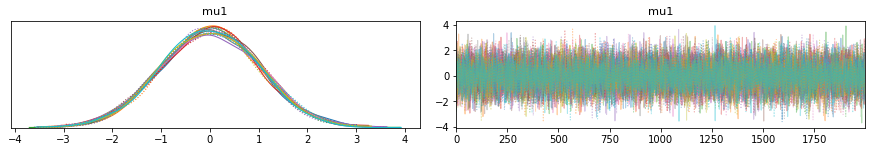

In [9]:
def test():
  model1 = pm.Model()
  with model1:
      mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)
      print(type(mu1))

  with model1:
      step = pm.NUTS()
      trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2)
  with model1:
    mu_test = pm.Normal("mu_test", mu=mu1, sigma=1, shape=10)
  return mu1, model1

mu1, model1 = test()

print(type(mu1))

def test2(mu1, model):
  model1 = model
  print(type(mu1))
  with model1:
      mu2 = pm.Normal("mu2", mu=mu1, sigma=1, shape=10)

  with model1:
      step = pm.NUTS()
      trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2)
  return mu2, trace

mu2, trace = test2(mu1, model1)

pm.traceplot(trace, var_names=['mu1'])

In [0]:
# nuts_trace = pm.save_trace(trace_multivar[0])
# with multivar_normal_thdp:
#   trace_2 = pm.load_trace(nuts_trace)
pm.traceplot(trace_multivar[0], var_names=['alpha_0'])
pm.traceplot(trace_multivar[0], var_names=['beta_0'])
pm.traceplot(trace_multivar[0], var_names=['w_0'])
pm.traceplot(trace_multivar[0], var_names=['mu_0'])

In [0]:
multi_G_0_list = pd.read_csv('/content/thdp_G_0.csv')
multi_G_0_list = np.array_split(multi_G_0_list, 10)
# print(len(multi_data_list))

for multi_G_0_frame in multi_G_0_list:
  g = sns.jointplot(x="x1", y="x2", data=multi_G_0_frame, kind="kde", color="m")
  g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
  g.ax_joint.collections[0].set_alpha(0)
  g.set_axis_labels("$X$", "$Y$");

## Text Data - word2vec embeddings

### Loading Data

In [0]:
# The number of words in the vocabulary
n_words = 50

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, 
                                max_features=n_words, 
                                # If not None, build a vocabulary that 
                                # only consider the top max_features 
                                # ordered by term frequency across the corpus.
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

INFO:sklearn.datasets._twenty_newsgroups:Downloading 20news dataset. This may take a few minutes.
INFO:sklearn.datasets._twenty_newsgroups:Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Loading dataset...
done in 13.402s.
Extracting tf features for LDA...
done in 1.587s.


In [0]:
tf.toarray()[0:5].shape

(5, 50)

In [0]:
tf.toarray().shape

(11314, 50)

In [0]:
data_samples[0:5]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [0]:
len(feature_names)

50

In [0]:
feature_names

['10',
 'available',
 'ax',
 'believe',
 'bit',
 'com',
 'data',
 'did',
 'does',
 'don',
 'edu',
 'file',
 'god',
 'going',
 'good',
 'government',
 'information',
 'just',
 'key',
 'know',
 'like',
 'll',
 'make',
 'max',
 'need',
 'new',
 'number',
 'people',
 'point',
 'problem',
 'program',
 'really',
 'right',
 'said',
 'say',
 'space',
 'thanks',
 'things',
 'think',
 'time',
 'use',
 'used',
 'using',
 've',
 'want',
 'way',
 'windows',
 'work',
 'year',
 'years']

### Preprocessing

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
'aa,fsad' + 'fadsfa'

'aa,fsadfadsfa'

In [0]:
# Cleaing the text
processed_article = ''
for paragraph in data_samples:
    processed_article += paragraph
    processed_article += ' '

In [0]:
processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
processed_article = re.sub(r'\s+', ' ', processed_article)

# Preparing the dataset
all_sentences = nltk.sent_tokenize(processed_article)

all_words = [nltk.word_tokenize(sent) for sent in all_sentences]


# Removing Stop Words
from nltk.corpus import stopwords
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]
    

from gensim.models import Word2Vec

word2vec = Word2Vec(all_words, size=5, min_count=1)

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 91871 word types from a corpus of 1473347 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 91871 unique words (100% of original 91871, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 1473347 word corpus (100% of original 1473347, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 91871 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 25 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 1352126 word corpus (91.8% of prior 1473347)
INFO:gensim.models.base_any2vec:estimated required memory for 91871 words and 5 dimensions:

In [0]:
vocabulary = word2vec.wv.vocab
print(vocabulary)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
word2vec.wv['try'].shape

(5,)

In [0]:
word2vec.wv['try']

array([-0.07029817, -0.07513822,  0.10106148,  0.07985469, -0.05014382],
      dtype=float32)

In [0]:
word2vec.wv['try']

array([-0.07029817, -0.07513822,  0.10106148,  0.07985469, -0.05014382],
      dtype=float32)

In [0]:
word_data = {}
for word in feature_names:
  try:
    word_data[word] = list(word2vec.wv[word])
  except:
    print(word)
word_data = pd.DataFrame(word_data).T
word_data

10
did
does
don
just
ll
ve


,0,1,2,3,4
available,-0.006508,-0.085130,0.082661,-0.073088,-0.048726
ax,0.008711,0.076483,-0.049009,0.091068,0.016200
believe,0.000986,0.066922,0.095592,0.088014,-0.054103
bit,0.089773,0.052033,-0.058612,-0.057924,0.056842
com,-0.066836,0.112322,0.110275,0.137354,-0.033214
data,0.051904,-0.011635,0.101900,0.056500,0.033989
edu,-0.090917,0.186027,0.162505,0.232943,0.195353
file,-0.018839,0.073877,0.085618,0.048439,0.056299
god,-0.028516,0.084628,-0.003297,0.095973,-0.030584
going,-0.047690,-0.004181,-0.061503,-0.026665,-0.003392


### Test on Word Data

#### Generate word data dictionary for a corpus

In [0]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
# clean up the text data
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def generate_word_data_dict(corpus_list, n_words):
    corpus_dict = {'doc'+str(i): item for i, item in enumerate(corpus_list)}

    word_data_dict = {}

    for j, doc in enumerate(corpus_dict.keys()):
          # Cleaing the text
          processed_article = ''
          for paragraph in corpus_dict[doc]:
              processed_article += paragraph
              processed_article += ' '


          # learn a tf vectorizer and 
          tf_vectorizer_j = CountVectorizer(max_df=0.95, min_df=2, 
                                    max_features=n_words, 
                                    # If not None, build a vocabulary that 
                                    # only consider the top max_features 
                                    # ordered by term frequency across the corpus.
                                    stop_words='english')
          t0 = time()
          doc_j = tf_vectorizer_j.fit_transform(corpus_list[j])  
          feature_names_j = tf_vectorizer_j.get_feature_names()
          print("done in %0.3fs." % (time() - t0))


          processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
          processed_article = re.sub(r'\s+', ' ', processed_article)

          # Preparing the dataset
          all_sentences = nltk.sent_tokenize(processed_article)
          all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

          # Removing Stop Words
          for i in range(len(all_words)):
              all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]

          word2vec = Word2Vec(all_words, size=5, min_count=1)

          # {'doc'+str(i): item for i, item in enumerate(corpus_list)}

          word_data = {}

          ###################################################################
          ##### feature_names need to be different for different docs ??? ########
          ###################################################################

          for word in feature_names_j:
            try:
              word_data[word] = list(word2vec.wv[word])
            except:
              print(word)
          word_data = pd.DataFrame(word_data).T

          # print(word_data)
          print('w2c_doc'+str(j))
          print('item index: ', j)
          word_data_dict['w2c_doc'+str(j)] = word_data


    return word_data_dict


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# The number of words in the vocabulary
n_words = 100

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data



# let us split the data samples into 3 documents
# and store them in a corpus dictionary
doc1 = data_samples[:3771]
doc2 = data_samples[3771:7542]
doc3 = data_samples[7542:]

# corpus_list needs to be initialized with list of text data
corpus_list = [doc1, doc2, doc3]
# input for the corpus preparation function

In [0]:
# This is going to take a while
word_data_dict = generate_word_data_dict(corpus_list, n_words)
word_data_dict

done in 0.588s.


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 50242 word types from a corpus of 461596 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 50242 unique words (100% of original 50242, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 461596 word corpus (100% of original 461596, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 50242 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 26 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 430400 word corpus (93.2% of prior 461596)
INFO:gensim.models.base_any2vec:estimated required memory for 50242 words and 5 dimensions: 27130680 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model

00
10
15
16
20
50
did
didn
does
doesn
don
g9v
just
ll
mr
ve
w2c_doc0
item index:  0
done in 0.588s.


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 48144 word types from a corpus of 501377 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 48144 unique words (100% of original 48144, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 501377 word corpus (100% of original 501377, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 48144 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 17 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 454988 word corpus (90.7% of prior 501377)
INFO:gensim.models.base_any2vec:estimated required memory for 48144 words and 5 dimensions: 25997760 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model

00
000
10
12
15
16
20
did
didn
does
doesn
don
just
ll
mr
ve
w2c_doc1
item index:  1
done in 0.650s.


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 50709 word types from a corpus of 510374 raw words and 1 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=1 retains 50709 unique words (100% of original 50709, drops 0)
INFO:gensim.models.word2vec:effective_min_count=1 leaves 510374 word corpus (100% of original 510374, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 50709 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 27 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 462309 word corpus (90.6% of prior 510374)
INFO:gensim.models.base_any2vec:estimated required memory for 50709 words and 5 dimensions: 27382860 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model

0t
10
11
12
14
145
15
16
17
1d9
20
25
30
34u
a86
ax
b8f
did
didn
does
doesn
don
g9v
just
ll
ve
w2c_doc2
item index:  2


{'w2c_doc0':                   0         1         2         3         4
 available  0.038077  0.011508  0.030364  0.094245 -0.107526
 ax         0.062589  0.069776  0.026533 -0.028255 -0.057855
 believe    0.005061  0.096877 -0.086642 -0.021807  0.085890
 best      -0.002308 -0.098336 -0.003179  0.076473  0.057623
 better     0.035478  0.007989  0.080631 -0.092159  0.000618
 ...             ...       ...       ...       ...       ...
 windows    0.078489  0.096586  0.012316 -0.041961 -0.010182
 work      -0.077862 -0.042874  0.058442  0.029051 -0.045909
 world     -0.041104  0.073556  0.052317  0.073630 -0.023399
 year      -0.080787 -0.046278  0.071690  0.027289  0.034298
 years     -0.080007  0.035614 -0.008101  0.097384 -0.002831
 
 [84 rows x 5 columns],
 'w2c_doc1':                   0         1         2         3         4
 available  0.028130  0.022364  0.029385  0.077153 -0.095895
 ax         0.062589  0.069776  0.026533 -0.028255 -0.057855
 believe    0.019898  0.103747 -0.0

#### MvNorm HDP with identity covariance matrix

In [0]:
# define a MvNorm_HDP with non priors on covariance matrix, for the purpose of efficient computation

def MvNorm_HDP(word_data_dict, dim, K_topics, M_topics_per_doc, n_samples, mcmc): 

    def stick_breaking(beta):
      portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
      return beta * portion_remaining
    
    # dim = np.shape(data)[1]
    dim = dim

    cov_I = np.zeros((dim,dim))
    for i in range(dim):
      cov_I[i,i] = 1

    with pm.Model() as multivar_normal_hdp:
        
        ###############
        # Topics DP
        ###############

        alpha_0 = pm.Gamma('alpha_0', 1., 1.)
        beta_0 = pm.Beta('beta_0', 1., alpha_0, shape=K_topics)
        w_0 = pm.Deterministic('w_0', stick_breaking(beta_0))

        # Get samples from normal 
        # tau_0 = pm.Gamma('tau_0', 1., 1., shape=K_topics)
        # lambda_0 = pm.Uniform('lambda_0', 0, 5, shape=K_topics)

        mu_0 = pm.MvNormal('mu_0', np.zeros(dim), tau=cov_I, shape=(K_topics, dim))
        # atoms = pm.Normal('atoms', np.zeros(K_topics), tau=tau_0*lambda_0, shape=K_topics)  # Should this be a RV?

        # # set a prior on the covariance
        # packed_L = pm.LKJCholeskyCov('packed_L', n=dim,
        #                          eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        # L = pm.expand_packed_triangular(dim, packed_L)
        # cov0 = pm.Deterministic('cov0', L.dot(L.T))

        atoms = pm.MvNormal('atoms', mu_0, tau=cov_I, shape=(K_topics, dim))  # Should this be a RV?

        tmp = pm.Categorical('tmp', w_0, shape=M_topics_per_doc)
        sample_theta = pm.Deterministic('shared_theta', atoms[tmp])

        # tau_j = pm.Gamma('tau_j', 1., 1., shape=M_topics_per_doc)
        # lambda_j = pm.Uniform('lambda_j', 0, 5, shape=M_topics_per_doc)

        ###############
        # Doc DP
        ###############
        for j, doc in enumerate(word_data_dict.keys()):

            alpha_j = pm.Gamma('alpha_doc'+str(j), 1., 1.)   # We can choose to use the same alpha_0 as above
            beta_j = pm.Beta('beta_doc'+str(j), 1., alpha_j, shape=M_topics_per_doc)    # Same comment as above
            w_j = pm.Deterministic('w_doc'+str(j), stick_breaking(beta_j))

            comp_dists_list = []
            for m in range(M_topics_per_doc):

              # # set a prior on the covariance
              # packed_L_m = pm.LKJCholeskyCov('packed_L_'+str(m), n=dim,
              #                        eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
              # L_m = pm.expand_packed_triangular(dim, packed_L_m)
              # cov_m = pm.Deterministic('cov_'+str(m), L_m.dot(L_m.T))


              normal_m_j = pm.MvNormal('normal_'+str(m)+'_doc'+str(j), sample_theta[m], tau=cov_I, shape=dim)
              comp_dists_list.append(normal_m_j.distribution)

            ###############
            # Feed in word2vec embedding / text data
            ###############
            obs = pm.Mixture('obs_doc'+str(j), w_j, comp_dists = comp_dists_list, shape = M_topics_per_doc, 
                            #  observed=iris['data'][:,1:3])
                            observed=word_data_dict[doc])


    with multivar_normal_hdp:
        step_nuts = pm.step_methods.hmc.nuts.NUTS()
        step_metro = pm.step_methods.metropolis.Metropolis()

        if mcmc == 'nuts':
          step = step_nuts
        # elif mcmc == 'metro':
        else:
          step = step_metro
        trace_multivar = pm.sample(n_samples, step, random_seed=SEED, init='advi')
    return trace_multivar, multivar_normal_hdp

#### Testing HDP on text data

In [0]:
SEED = 1
K_topics = 50
M_topics_per_doc = 20
atoms = np.random.normal(0, .01, K_topics)

# dim = dim # dimension of word vectors
cov0 = np.zeros((5,5))
for i in range(5):
  cov0[i,i] = 1

# data = word_data
data = {0: multi_data_frame.iloc[:, 1:]}

n_samples = 2000
dim = 2

mcmc = 'nuts'

trace_word, multivar_normal_hdp = MvNorm_HDP(data, dim, K_topics, M_topics_per_doc, n_samples, mcmc)

Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [normal_19_doc0, normal_18_doc0, normal_17_doc0, normal_16_doc0, normal_15_doc0, normal_14_doc0, normal_13_doc0, normal_12_doc0, normal_11_doc0, normal_10_doc0, normal_9_doc0, normal_8_doc0, normal_7_doc0, normal_6_doc0, normal_5_doc0, normal_4_doc0, normal_3_doc0, normal_2_doc0, normal_1_doc0, normal_0_doc0, beta_doc0, alpha_doc0, atoms, mu_0, beta_0, alpha_0]
INFO:pymc3:>NUTS: [normal_19_doc0, normal_18_doc0, normal_17_doc0, normal_16_doc0, normal_15_doc0, normal_14_doc0, normal_13_doc0, normal_12_doc0, normal_11_doc0, normal_10_doc0, normal_9_doc0, normal_8_doc0, normal_7_doc0, normal_6_doc0, normal_5_doc0, normal_4_doc0, normal_3_doc0, normal_2_doc0, normal_1_doc0, normal_0_doc0, beta_doc0, alpha_doc0, atoms, mu_0, beta_0, alpha_0]
>CategoricalGibbsMetropolis: [tmp]
INFO:pymc3:>CategoricalGibbsMetropolis: [tmp]
Sampling chain 1, 1,999 divergences: 1

In [0]:
print(multivar_normal_hdp.basic_RVs)

[alpha_0_log__, beta_0_logodds__, mu_0, atoms, tmp, alpha_doc0_log__, beta_doc0_logodds__, normal_0_doc0, normal_1_doc0, normal_2_doc0, normal_3_doc0, normal_4_doc0, normal_5_doc0, normal_6_doc0, normal_7_doc0, normal_8_doc0, normal_9_doc0, normal_10_doc0, normal_11_doc0, normal_12_doc0, normal_13_doc0, normal_14_doc0, normal_15_doc0, normal_16_doc0, normal_17_doc0, normal_18_doc0, normal_19_doc0, obs_doc0]


In [0]:
pm.save_trace(trace_word)

'.pymc_4.trace'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc286f4d400>,
      dtype=object)

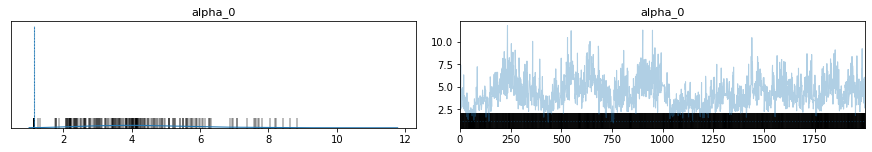

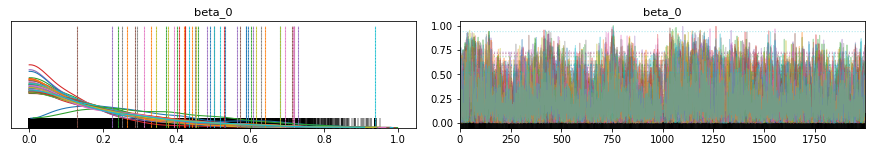

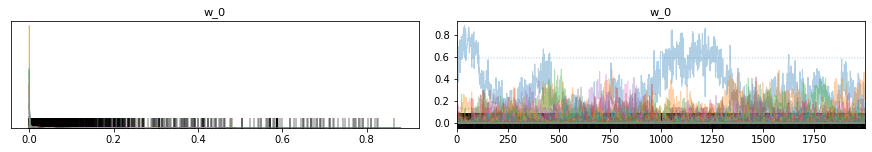

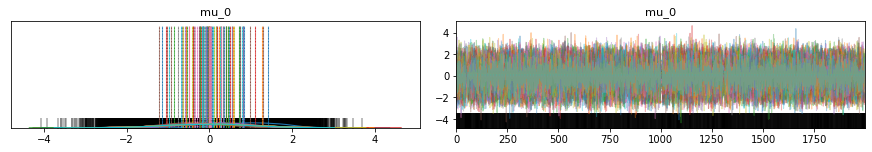

In [0]:
pm.traceplot(trace_word, var_names=['alpha_0'])
pm.traceplot(trace_word, var_names=['beta_0'])
pm.traceplot(trace_word, var_names=['w_0'])
pm.traceplot(trace_word, var_names=['mu_0'])

    Unnamed: 0        x1        x2
0            0  0.996336 -0.170581
1            1  0.383229  1.101193
2            2  1.785854  0.455777
3            3 -0.352170 -0.147207
4            4  0.794210 -0.849032
..         ...       ...       ...
95          95  1.453601 -0.265311
96          96  1.174406  0.392586
97          97 -1.568487 -0.318847
98          98  0.643376 -0.372615
99          99 -0.918956 -0.997533

[100 rows x 3 columns]


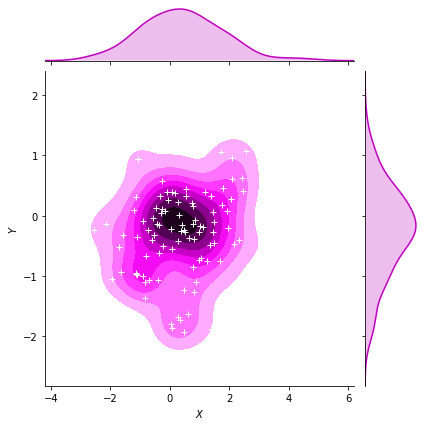

In [0]:
multi_G_0_frame = pd.read_csv('/content/hdp_G_0.csv')
print(multi_G_0_frame)

g = sns.jointplot(x="x1", y="x2", data=multi_G_0_frame, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");


In [0]:
pm.traceplot(trace_word, var_names=['normal_0'])
pm.traceplot(trace_word, var_names=['normal_1'])

KeyError: ignored

In [0]:
## means of clusters

print('w: ', trace_word['w_j'].mean(0))

for j in len(corpus_list):
  for i in range(M_topics_per_doc):
    print('normal_'+str(i)+': ', trace_word['normal_'+str(i)+'_'+str(j)].mean(0))

###### previous results when there was only one doc

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3955be14e0>,
      dtype=object)

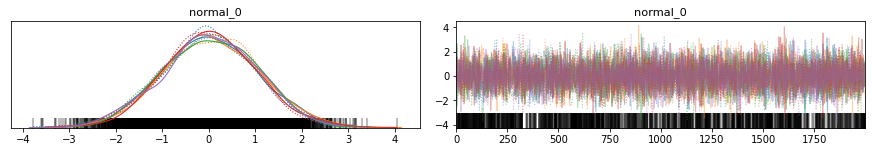

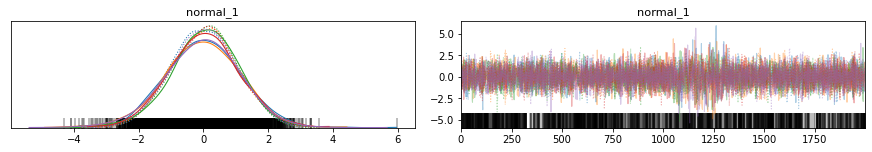

In [0]:
pm.traceplot(trace_word, var_names=['normal_0'])
pm.traceplot(trace_word, var_names=['normal_1'])

In [0]:
## means of clusters

print('w: ', trace_word['w_j'].mean(0))

for i in range(M_topics_per_doc):
  print('normal_'+str(i)+': ', trace_word['normal_'+str(i)].mean(0))

w:  [6.79536132e-01 1.99608152e-01 6.55704568e-02 3.09978660e-02
 1.31610142e-02 5.29788358e-03 2.85215316e-03 1.48727556e-03
 7.55430681e-04 3.40671443e-04 1.93504299e-04 1.00297678e-04
 4.74915291e-05 2.52459153e-05 1.40381606e-05 5.32867791e-06
 3.96811445e-06 1.83032828e-06 6.27710725e-07 3.48869238e-07]
normal_0:  [ 0.00869155  0.05415912 -0.01368119 -0.00664155 -0.00683762]
normal_1:  [-0.00161601 -0.00585903  0.0303811   0.01120986 -0.02254158]
normal_2:  [ 0.02963363  0.00960986  0.01511521  0.0668749  -0.02266475]
normal_3:  [0.01700456 0.00250865 0.01584564 0.04633785 0.00200757]
normal_4:  [-0.03988174  0.01551636 -0.00703662  0.01449294 -0.03215905]
normal_5:  [ 0.10699302 -0.01635295 -0.06471403 -0.04288492  0.00155056]
normal_6:  [ 0.01332326  0.01082283  0.00299261  0.0861457  -0.06197899]
normal_7:  [ 0.01027512 -0.02826813 -0.07427645 -0.0225976  -0.07216295]
normal_8:  [ 0.00876247 -0.06098347 -0.06641393 -0.00267373 -0.02462142]
normal_9:  [-0.00174298 -0.00830587  0

In [0]:
data = data.iloc[:,:5]
data

,0,1,2,3,4
available,0.100338,0.069079,0.056088,0.029124,0.040072
ax,-0.032376,-0.030692,-0.092690,-0.058271,-0.019312
believe,0.036580,0.016798,0.046783,0.031857,0.064211
bit,-0.046882,-0.090821,-0.044750,0.071148,0.078398
com,-0.047219,0.095413,0.014498,0.041890,-0.011387
data,0.078037,-0.100054,0.075304,-0.095135,-0.098266
edu,0.023755,-0.084373,0.085497,-0.105001,-0.124804
file,0.029552,-0.053031,-0.029680,-0.032185,-0.101361
god,-0.029879,0.069296,0.089173,-0.028970,0.096639
going,0.064049,-0.001810,0.067750,-0.038538,0.054884


In [0]:
trace_word['normal_'+str(0)].mean(0)[:5]

array([-0.00136703, -0.0221234 ,  0.00657363, -0.00943783, -0.00228608])

In [0]:
from scipy.stats import multivariate_normal
import operator

dim = np.shape(data)[1]    
# dim = 5
cov_I = np.zeros((dim,dim))
for i in range(dim):
  cov_I[i,i] = 1

param_posterior = {}
cluster_generative = {}

for m in range(M_topics_per_doc):
  mean_m = trace_word['normal_'+str(m)].mean(0)[:5]
  # mean_m = globals()['normal_' + str(m)]
  param_posterior['normal_'+str(m)] = mean_m
  cluster_generative['rv_'+str(m)] = multivariate_normal(mean_m, cov_I)

cluster_df = pd.DataFrame({'cluster': np.zeros(data.shape[0])})

for i in range(data.shape[0]):
  density_i = []
  for m in range(M_topics_per_doc):
    print(cluster_generative['rv_'+str(m)])
    density_i.append(cluster_generative['rv_'+str(m)].pdf(data.iloc[i,:].tolist()))


  index, value = max(enumerate(density_i), key=operator.itemgetter(1)) 
  cluster_df.iloc[i,:] = 'cluster_' + str(index)

data['cluster'] = cluster_df['cluster'].tolist()
data


,0,1,2,3,4,cluster
available,0.100338,0.069079,0.056088,0.029124,0.040072,cluster_8
ax,-0.032376,-0.030692,-0.092690,-0.058271,-0.019312,cluster_19
believe,0.036580,0.016798,0.046783,0.031857,0.064211,cluster_14
bit,-0.046882,-0.090821,-0.044750,0.071148,0.078398,cluster_10
com,-0.047219,0.095413,0.014498,0.041890,-0.011387,cluster_17
data,0.078037,-0.100054,0.075304,-0.095135,-0.098266,cluster_4
edu,0.023755,-0.084373,0.085497,-0.105001,-0.124804,cluster_4
file,0.029552,-0.053031,-0.029680,-0.032185,-0.101361,cluster_15
god,-0.029879,0.069296,0.089173,-0.028970,0.096639,cluster_16
going,0.064049,-0.001810,0.067750,-0.038538,0.054884,cluster_16


In [0]:
topic = {}
w_j = trace_word['w_j'].mean(0)
for m in range(M_topics_per_doc):
  words_topic_m = data.loc[data.cluster=='cluster_'+str(m),:].index.tolist()
  if len(words_topic_m) > 0:
    topic['cluster_'+str(m)] = [w_j[m], words_topic_m]

for cluster in topic.keys():
  print(cluster)
  print('prob: {}'.format(topic[cluster][0]))
  print('words: {}'.format(topic[cluster][1]), '\n')

cluster_0
prob: 0.6283760209075574
words: ['information'] 

cluster_1
prob: 0.21401929717515833
words: ['government'] 

cluster_3
prob: 0.035519767542386775
words: ['know', 'make', 'program', 'say', 'thanks', 'use', 'year'] 

cluster_4
prob: 0.015663644572414745
words: ['data', 'edu'] 

cluster_5
prob: 0.008516766154657488
words: ['said', 'windows'] 

cluster_7
prob: 0.0020184824827488416
words: ['need', 'point', 'time'] 

cluster_8
prob: 0.0011158210786838155
words: ['available', 'good', 'used', 'want', 'work'] 

cluster_9
prob: 0.0005258090552975321
words: ['new'] 

cluster_10
prob: 0.00028078397200558485
words: ['bit', 'people', 'right', 'using'] 

cluster_11
prob: 0.0001727615036386985
words: ['think'] 

cluster_12
prob: 9.835680455155067e-05
words: ['really'] 

cluster_13
prob: 4.594350198579201e-05
words: ['number', 'problem', 'space', 'things'] 

cluster_14
prob: 1.7442578844098572e-05
words: ['believe'] 

cluster_15
prob: 8.65518201596089e-06
words: ['file'] 

cluster_16
prob: 